1) Image is taken as a screenshot from the following <a href="https://www.researchgate.net/publication/262789203_Indoleamine_23-dioxygenase_IDO_is_frequently_expressed_in_stromal_cells_of_Hodgkin_lymphoma_and_is_associated_with_adverse_clinical_features_A_retrospective_cohort_study">paper</a> [Suggested by Dr. Askhat].

2) This code is created using the following <a href="https://www.youtube.com/watch?v=7u83l_HqamI&ab_channel=DigitalSreeni"> video tutorial</a>.

3) In addition, this <a href="https://haesleinhuepf.github.io/BioImageAnalysisNotebooks/20_image_segmentation/11_voronoi_otsu_labeling.html">source</a> was very useful to properly understand the main algorithm her.

### Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, io, img_as_ubyte
from skimage.color import rgb2hed, hed2rgb
from skimage.exposure import rescale_intensity

import pyclesperanto_prototype as cle #main algorithm is HERE!!!

import pandas as pd

### Convert RGB into HED (to find only brown cells)

In [2]:
def color_separate(ihc_rgb):

    ihc_hed = rgb2hed(ihc_rgb)
    null = np.zeros_like(ihc_hed[:, :, 0])
    ihc_h = img_as_ubyte(hed2rgb(np.stack((ihc_hed[:,:,0], null, null), axis = -1)))
    ihc_e = img_as_ubyte(hed2rgb(np.stack((null, ihc_hed[:,:,1], null), axis = -1)))
    ihc_d = img_as_ubyte(hed2rgb(np.stack((null, null, ihc_hed[:,:,2]), axis = -1)))

    h = rescale_intensity(ihc_hed[:, :, 0], out_range=(0, 1),
                            in_range = (0, np.percentile(ihc_hed[:,:,0], 99)))
    d = rescale_intensity(ihc_hed[:, :, 2], out_range=(0, 1),
                            in_range = (0, np.percentile(ihc_hed[:,:,2], 99)))

    zdh = img_as_ubyte(np.dstack((null, d, h)))
    return (ihc_h, ihc_e, ihc_d, zdh)

In [3]:
new_img = "test.jpg"
ihc_rgb = io.imread(new_img)

In [4]:
H, E, D, HD = color_separate(ihc_rgb)

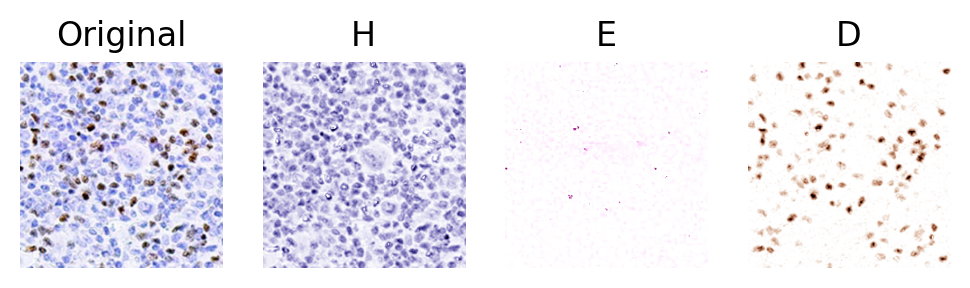

In [5]:
fig, axs = plt.subplots(1,4)
fig.set_dpi(200)
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')
axs[0].title.set_text('Original')
axs[1].title.set_text('H')
axs[2].title.set_text('E')
axs[3].title.set_text('D')
axs[0].imshow(ihc_rgb)
axs[1].imshow(H)
axs[2].imshow(E)
axs[3].imshow(D)

In [6]:
# Make dark background and bright cells
input_image = np.invert(D[:, :, 2])
# plt.imshow(input_image, cmap='gray')

### Main algorithm for image segmentation

In [7]:
# device = cle.select_device(cle.available_device_names(dev_type='gpu')[0])
# device
# input_gpu = cle.push(input_image)
input_gpu = input_image

#IMPORTANT PARAMETERS THAT CAN BE TUNED BY USER
sigma_spot_detection = 3
sigma_outline = 1

segmented = cle.voronoi_otsu_labeling(input_gpu, spot_sigma=sigma_spot_detection, 
                                      outline_sigma=sigma_outline)

In [8]:
statistics = cle.statistics_of_labelled_pixels(input_gpu, segmented) 
table = pd.DataFrame(statistics)   

# table.describe()
# table.info()

### <span style="color:red">FINAL RESULT</span>

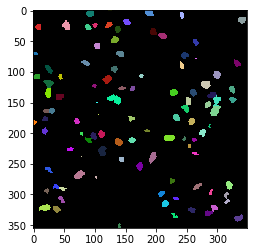

In [9]:
cle.imshow(segmented, labels=True)

In [10]:
print('Number of brown cells is ', int(table.describe().label[0]))

Number of brown cells is  104
